In [21]:
using Plots
using LinearAlgebra

### Observaciones para definir a la función de ´velocidad de Verlet´
La función velocidad Verlet, debe resolver la ec. diferencial para $R_k+1$,
invlucrando términos $v_k$, $F_k$, y $F_k+1$.

Además, distintos parámetros como el paso temporal, masas, tiempo inicial y final, y 
posición inicial y velocidad inicial.

OJO: Necesitamos que tanto la posición inicial y velocidad inicial sean arreglos de vectores, es decir, $R^{0} = (R^{0}_1, R^{0}_2, ... , R^{0}_k)$
y lo mismo para la velocidad, $V^{0} = (V^{0}_1, V^{0}_2, ... , V^{0}_k)$. La notación es la siguiente: $R^{i}_{k}$, $i$ denota el tiempo, y $k$ a la partícula.

Ahora, por qué $R$ y $V$ son arreglos de vectores? Justo, porque $R_{k}$ es la posición $(x,y)$ de la k-ésima partícula.

NOTA: Es factible definir así a R y V ? o una forma más fácila sería por un lado calcular las posiciones y velocidades en $x$ y por otro las de $y$. ?

El algoritmo completo de   _velocidad Verlet_ está definido como:

$$\begin{equation}
R_{k+1} = R_{k} +  V_{k}h + \frac{1}{2}F_{k} h^{2}, \\
V_{k+1} = V_{k} + \frac{1}{2}(F_{k} + F_{k+1})h .
\end{equation}$$

Con  $R_{k} = (R_1, R_2, ... , R_k)$ y $V_{k} = (V_1, V_2, ... , V_k)$, y a su vez, cada $R_{k} = (x_{k}, y_{k})$ y $V_{k} = (v_{x_k}, v_{y_k})$

#### Sistema de Referencia

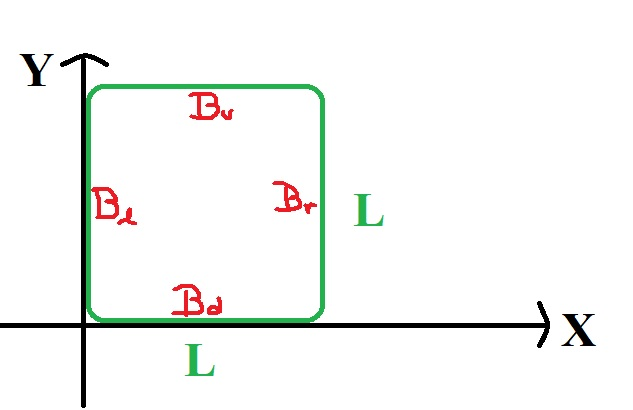

#### Condiciones de frontera

Las condiciones de frontera que vamos a trabajar son 4 paredes reflejantes, eso significa que debemos verificar en cada resultado si no sobrepasa el valor de la caja, por ejemplo, para la parede derecha, considerando que la partícula viene viajando de izquierda a derecha:
$$\begin{equation}
R_{k+1} = (x_{k+1}, y_{k+1}) = (L - (x'_{k+1} - L), y'_{k+1}), \\
V_{k+1} = (v_{x_k+1}, v_{y_k+1}) = (-v'_{x_k+1}, v'_{y_k+1}).
\end{equation}$$
 NOTA: Es la misma idea para cada pared en cada coordenada, significa que si en nuestro programa verficamos con un _if_ este sería para 4 paredes.

In [22]:
#Estableciendo las partículas, en la posición (X,Y)
# Atoms debe ser un entero positivo mayor a 2.
atoms_N = 100 #[-]
# Debido a que vamos a trabajar N partículas idénticas, definimos el valor de la masa que es el mismo para las N.
masa = 1.0 #[kg]
# Establecemos la dimensión de la caja, el valor de "L"
box_size = 30.0 # nm
#= Y establecemos las posiciones iniciales de las N partículas de manera aleatoria. 
Multiplicamos por box_size a cada elementos de la lista para que los valores estén dentro de la caja. =#

# Coordenadas de las partículas, inicialmente
coords = [box_size .* [rand(),rand()] for i in 1:3]
#Esta lista es importante y debe ser la lista que se ocupe para encontrar las posiciones, velocidades y fuerzas incialmente.

3-element Array{Array{Float64,1},1}:
 [14.4199, 6.45643]
 [26.563, 29.1881] 
 [11.0136, 2.91611]

In [29]:
#Cómo visualizamos esto ?
for k in 1:3
    xs = coords[k][1]
    ys = coords[k][2]
    scatter!(xs,ys, title="N partículas inicialemente",xlabel="Eje x", ylabel="Eje y",
        xlim=(0,30),ylim=(0,30),legend=:none)
end
#scatter(coords[1])
#scatter!(coords[2])
#scatter!(coords[3])

ErrorException: Cannot convert Float64 to series data for plotting

#### Aquí falta ver gráficas

Una vez establecido el sistema y teniendo en consideración cuales van a ser las condiciones de frontera, continumos en encontar las listas $R^{0}_{k}$, $V^{0}_{k}$ y $F^{0}_{k}$. Veamos la estructura de un elemento de $R_{k}$.

Ya habiamos dicho que $R_{k} = (R_1, R_2, ... , R_k)$, y $R_{1}$ el cuál corresponde a nuestras posiciones iniciales tiene la siguiente forma:
$$\begin{align}
R_{1} &= [R^{1}_{p1}, R^{1}_{p2}, ..., R^{1}_{pN}], \\
&= [(p1_{x},p1_{y}), (p2_{x},p2_{y}), ... , (pN_{x}, pN_{y})].
\end{align}$$

La pregunta es, como prealoco una lista con esta estructura? o es conveniente tener una lista para las posiciones en $x$ aparte de las de $y$?, tuplas o arreglos?.

La misma estructura tendrá la lista de velocidades.

Por otra parte, las fuerzas. De la teoría sabemos que la fuerza total en este sistema es:
$$\begin{equation}
\vec{F}_{k} = \sum_{i \neq j} \vec{f}_{ij} + \vec{f}_{ext}^{i}
\end{equation}$$

donde el $f_{ij}$ corresponde a la interacción a pares de partículas y corresponde a $-\nabla U$ donde $U$ es el potencial de Lennard-Jones. Y $f_{ext}^{i}$ la fuerza gravitacional. Entonces:
$$\begin{equation}
\vec{F}_{k} = \sum_{i \neq j}\left[ \frac{24\sigma}{r^{2}_{ij}}\left(2 \left(\frac{\epsilon}{r_{ij}} \right)^{12}  - \left(  \frac{\epsilon}{r_{ij}}\right)^{6} \right) \vec{r}_{ij} + mg \right]
\end{equation}$$

NOTA: Cuál es la fuerza de gravedad ? debería de ser vector para que tenga sentido.

In [5]:
#Lista de posición inicial. El cuál será una lista de listas con dos entradas, PERO es la misma que "coords"
#coords2 = [zeros(1,2) for i in 1:3]
coords2 = coords
#La lista con velocidades inciales, sí la definimos, pero inicialmente todas las partículas tienen velocidad cero.
velocy2 = [zeros(1,2) for i in 1:3]
#norm(coords2[1] - coords2[2])

function LennardForce(Lista)
    dim = length(Lista)
    Fuerzas = [zeros(dim) for i in 1:dim]
    for i in 1:dim
        Sumfuerza = [0,0]
        for k in 1:dim
            if i != k
                Difi = Lista[i] - Lista[k]
                normi = norm(Difi)
                F1 = 2.0*(1/normi)^(12)
                F2 = (1/normi)^(6)
                F3 = (24.0)/((normi)^2)
                fuerzai = F3*(F1 - F2)*Difi
                Sumfuerza = Sumfuerza + fuerzai
            end
        end
        Fuerzas[i] = Sumfuerza
    end
return Fuerzas
end

LennardForce (generic function with 1 method)

In [10]:
Lista1Fuerza = LennardForce(coords)

3-element Array{Array{Float64,1},1}:
 [-0.837398, 2.07844]     
 [9.10647e-8, -3.24953e-8]
 [0.837398, -2.07844]     

In [7]:
#Función auxiliar, derivada central:
function DifCent(f,x,h)
    c = f(x+h) - f(x-h)
    der = c/(2*h)
    return der
end

DifCent (generic function with 1 method)

In [19]:
#Función velocidad Verlet
function SpeedVerlet(R_0,V_0,F_0,h,m,t0,tf)
#Definiciones previas:
    arrt = t0:h:tf
    N = length(arrt)
    M = length(R_0)
#Prealocamos listas:
    Force = [zeros(M) for i in 1:M]
    Posit = [zeros(1,2) for i in 1:M]
    Velcy = [zeros(1,2) for i in 1:M]    
#Asignamos los elementos iniciales a las listas:
    Force[1] = F_0
    #Velcy[1] = V_0
    #Posit[1] = R_0

############ Método de velocity Verlet
    return(Force)
end

SpeedVerlet (generic function with 1 method)

In [20]:
SpeedVerlet(coords2,velocy2,Lista1Fuerza,1,1,1,4)

MethodError: MethodError: Cannot `convert` an object of type Array{Float64,1} to an object of type Float64
Closest candidates are:
  convert(::Type{T<:Number}, !Matched::T<:Number) where T<:Number at number.jl:6
  convert(::Type{T<:Number}, !Matched::Number) where T<:Number at number.jl:7
  convert(::Type{T<:Number}, !Matched::Base.TwicePrecision) where T<:Number at twiceprecision.jl:250
  ...